# uncensored gamma population model

In [1]:
cd /home/makinen/repositories/fishnets/

/home/makinen/repositories/fishnets


In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
#import torch
import jax
from jax import lax
#import jax_cosmo as jc
import scipy.constants as cnst
import scipy.stats as ss

import matplotlib.pyplot as plt

import numpy as np
import numpyro
import numpyro.distributions as dist

import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import trange
from scipy import stats
tfk = tf.keras

from fishnets import *

/softs/python/py3mods/tensorflow/2.8.4/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [3]:
def gamma_pop_model(key, theta, 
                    n_data=500, 
                    serum_min=0.2, 
                    tmax=10.,
                    A=500.0):

  population = jnp.zeros((n_data, 2))
  mean, scale = theta # shape, reporting delay
  rate = 1./ scale #concentration / report_delay
  concentration = mean / scale
  key,rng = jax.random.split(key)

  def fn(key):
    #data,key = data_tuple
    key,rng = jax.random.split(key)
    decay_time = dist.Gamma(concentration=concentration, 
                           rate=rate).sample(key, ())

    key,rng = jax.random.split(key)
    measurement_time = dist.Uniform(low=0.0, high=tmax).sample(key, ())

    key,rng = jax.random.split(key)
    _lambda = A * jnp.exp(-measurement_time / decay_time )
    measured_serum_level = dist.Poisson(rate=_lambda).sample(key, ())

    #measured_serum_level += dist.Normal(loc=0.0, scale=0.2).sample(key, ())

    return jnp.array([measurement_time, measured_serum_level]) #, key

  # vmap without censoring
  keys = jax.random.split(key, num=n_data)
  population = jax.vmap(fn)(keys)

  return population

In [4]:
# now generate a shitton of simulations over a prior for theta

n_sims = 100000

# theta = (concentration, rate)
# mean of Gamma = concentration / rate
key = jax.random.PRNGKey(33)
mean = dist.Uniform(low=0.5, high=10.).sample(key, (n_sims,))
key,rng = jax.random.split(key)
scale = dist.Uniform(low=0.1, high=1.5).sample(key, (n_sims,))


theta = jnp.vstack([mean, scale]).T

In [5]:
# # now make sims
keys = jax.random.split(jax.random.PRNGKey(0), num=n_sims)
%time data = jax.vmap(gamma_pop_model)(keys, theta)

CPU times: user 9.54 s, sys: 2.42 s, total: 12 s
Wall time: 4.68 s


(array([17.,  7.,  9.,  5., 15., 17., 13.,  9.,  9., 14., 16., 12.,  9.,
        15., 13., 13., 12., 12., 17., 13., 14., 12.,  9.,  7., 14.,  8.,
        13., 15., 14.,  6.,  5., 11.,  9.,  7.,  5.,  7.,  6.,  5.,  9.,
         4.,  5.,  8.,  6.,  8.,  3.,  1.,  1.,  7.,  6.,  6.,  4.,  2.,
         2.,  2.,  3.,  2.,  1.,  4.,  1.,  1.]),
 array([  0.      ,   8.883333,  17.766666,  26.65    ,  35.533333,
         44.416668,  53.3     ,  62.183334,  71.066666,  79.95    ,
         88.833336,  97.71667 , 106.6     , 115.48333 , 124.36667 ,
        133.25    , 142.13333 , 151.01666 , 159.9     , 168.78334 ,
        177.66667 , 186.55    , 195.43333 , 204.31667 , 213.2     ,
        222.08333 , 230.96666 , 239.85    , 248.73334 , 257.61667 ,
        266.5     , 275.38333 , 284.26666 , 293.15    , 302.03333 ,
        310.91666 , 319.8     , 328.68332 , 337.56668 , 346.45    ,
        355.33334 , 364.21667 , 373.1     , 381.98334 , 390.86667 ,
        399.75    , 408.63333 , 417.51666 , 42

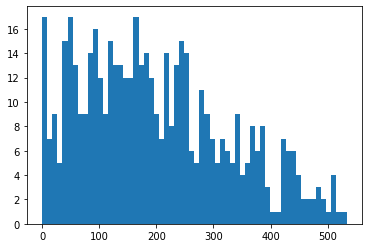

In [6]:
plt.hist(np.array(data[200, :, 1]), bins=60)

In [7]:
np.save('./gamma_pop/data_gamma_uncensored.npy', data)
np.save('./gamma_pop/theta_gamma_uncensored.npy', theta)

# fishnets models

In [3]:
n_sims = 100000
datadir = "/data80/makinen/fishnets/gamma_pop/data/"

# load theta and data
theta = np.load(datadir + 'theta_gamma_uncensored.npy')
data = np.load(datadir + 'data_gamma_uncensored.npy')

In [4]:
datamax = 500. #np.max(data[:, :, 1])
tmax = 10.

full_data = np.zeros((100000,500,2))
full_data[:, :, 0] = data[:, :, 0] / tmax
full_data[:, :, 1] = data[:, :, 1] / datamax
#full_data[:, :, 2] = x1
#full_data[:, :, 3] = x2; del data
data = full_data

In [5]:
import numpy as np

n_sims = 100000
n_data = 500
n_theta = 2

tmax=10. # days
serum_max_val=4.0

theta_fid = tf.constant([5.0, 0.8], dtype=tf.float32) 
theta_fid_ = theta_fid.numpy()

# stack up the data and parameters
data = tf.convert_to_tensor(data, dtype=tf.float32)
theta = tf.convert_to_tensor(theta, dtype=tf.float32)

# construct masks
score_mask = np.ones((n_sims, n_data, n_theta))
fisher_mask = np.ones((n_sims, n_data, n_theta, n_theta))


score_mask = tf.convert_to_tensor(score_mask, dtype=tf.float32)
fisher_mask = tf.convert_to_tensor(fisher_mask, dtype=tf.float32)

In [19]:
Model = FishnetTwin(n_parameters=n_theta, 
                n_inputs=2, 
                n_hidden_score=[256, 256, 256], 
                activation_score=[tf.nn.elu, tf.nn.elu,  tf.nn.elu],
                n_hidden_fisher=[256, 256, 256], 
                activation_fisher=[tf.nn.elu, tf.nn.elu,  tf.nn.elu],
                optimizer=tf.keras.optimizers.Adam(lr=5e-4),
                theta_fid=theta_fid,
                priormu=tf.zeros(n_theta, dtype=tf.float32),
                priorCinv=tf.eye(n_theta, dtype=tf.float32))

/softs/python/py3mods/tensorflow/2.8.4/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
# new fisher function calculaion
@tf.function
def construct_fisher_matrix(outputs):
    
    Q = tfp.math.fill_triangular(outputs)
    # EDIT: changed to + softplus(diag_part(Q))
    L = Q - tf.linalg.diag(tf.linalg.diag_part(Q) - tf.math.softplus(tf.linalg.diag_part(Q)))
    return tf.einsum('...ij,...jk->...ik', L, tf.transpose(L, perm=[0, 1, 3, 2]))

Model.construct_fisher_matrix = construct_fisher_matrix

In [23]:
Model.train((data, theta, score_mask, fisher_mask), lr=5e-5, epochs=300, lossfn='kl')

  0%|          | 0/300 [00:15<?, ?it/s, loss=3.21]


KeyboardInterrupt: 

In [8]:
# model MLEs
mle, F  = Model.compute_mle_(data[:10000], score_mask[:10000], fisher_mask[:10000])

100%|██████████| 50/50 [00:03<00:00, 12.54it/s]


In [14]:
F[:10]

<tf.Tensor: shape=(10, 2, 2), dtype=float64, numpy=
array([[[13.69861221, -3.41973352],
        [-3.41973352,  7.35654783]],

       [[18.46552849, -4.34109116],
        [-4.34109116, 10.5675354 ]],

       [[12.70514774, -3.06048775],
        [-3.06048775,  6.66834974]],

       [[21.5755806 , -4.75743914],
        [-4.75743914, 13.03299522]],

       [[11.21801949, -2.62859225],
        [-2.62859225,  5.79277658]],

       [[12.37452126, -2.91606545],
        [-2.91606545,  6.46781921]],

       [[12.15125084, -2.86405444],
        [-2.86405444,  6.34417725]],

       [[11.51825619, -2.66524506],
        [-2.66524506,  5.94216537]],

       [[13.05808163, -3.10783601],
        [-3.10783601,  6.79127455]],

       [[20.66851044, -4.5941925 ],
        [-4.5941925 , 11.81038475]]])>

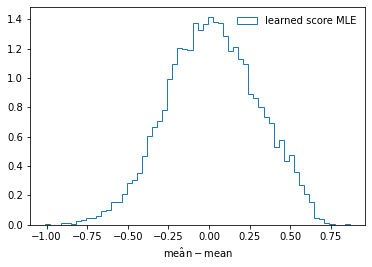

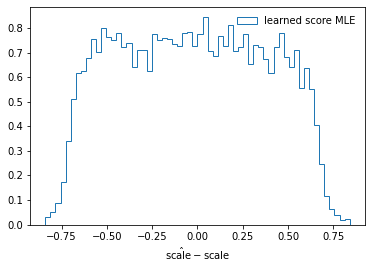

In [13]:
#plt.hist(mle_flow[:,0].numpy() - theta[:,0].numpy(), bins = 60, histtype='step', density=True, label='flow score MLE')
plt.hist(mle[:10000,0].numpy() - theta[:10000,0].numpy(), bins = 60, histtype='step', density=True, label='learned score MLE')
plt.xlabel(r'$\hat{\rm mean} - \rm{mean}$')
plt.legend(frameon=False)
plt.show()


#plt.hist(mle_flow[:,1].numpy() - theta[:,1].numpy(), bins = 60, histtype='step', density=True, label='flow score MLE')
plt.hist(mle[:10000,1].numpy() - theta[:10000,1].numpy(), bins = 60, histtype='step', density=True, label='learned score MLE')
plt.xlabel(r'$\hat{\rm scale} - \rm scale$')
plt.legend(frameon=False)
plt.show()

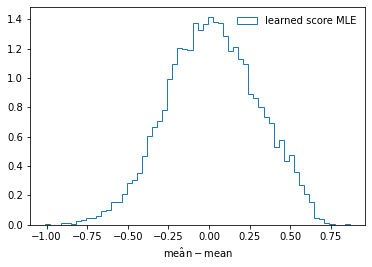

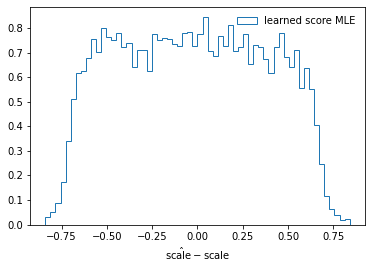

In [11]:
#plt.hist(mle_flow[:,0].numpy() - theta[:,0].numpy(), bins = 60, histtype='step', density=True, label='flow score MLE')
plt.hist(mle[:10000,0].numpy() - theta[:10000,0].numpy(), bins = 60, histtype='step', density=True, label='learned score MLE')
plt.xlabel(r'$\hat{\rm mean} - \rm{mean}$')
plt.legend(frameon=False)
plt.show()


#plt.hist(mle_flow[:,1].numpy() - theta[:,1].numpy(), bins = 60, histtype='step', density=True, label='flow score MLE')
plt.hist(mle[:10000,1].numpy() - theta[:10000,1].numpy(), bins = 60, histtype='step', density=True, label='learned score MLE')
plt.xlabel(r'$\hat{\rm scale} - \rm scale$')
plt.legend(frameon=False)
plt.show()

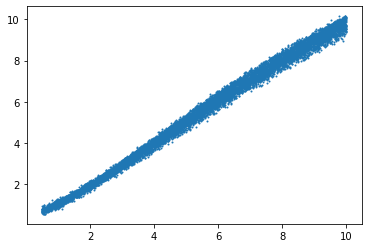

In [17]:
plt.scatter(theta[:10000, 0].numpy(), mle[:10000, 0].numpy(), s=1)

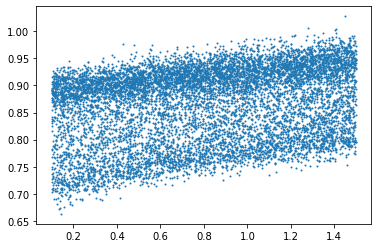

In [18]:
plt.scatter(theta[:10000, 1].numpy(), mle[:10000, 1].numpy(), s=1)

In [34]:
np.std(theta[:10000, 0].numpy()), np.std(mle[:10000,0].numpy() - theta[:10000,0].numpy())

(2.729305, 0.1295409178664161)

In [35]:
np.std(theta[:10000, 1]), np.std(mle[:10000,1].numpy() - theta[:10000,1].numpy())

(0.4017106, 0.1229592109359784)

(array([ 21.,  57., 125., 186., 214., 196., 202., 241., 179., 226., 210.,
        207., 217., 208., 196., 211., 216., 204., 177., 204., 221., 230.,
        208., 225., 199., 232., 200., 230., 204., 199., 224., 193., 214.,
        211., 201., 203., 219., 188., 213., 214., 207., 201., 200., 190.,
        189., 191., 186., 165., 132., 112.,  78.,  65.,  66.,  30.,  20.,
         20.,  10.,   7.,   4.,   2.]),
 array([0.4523078 , 0.47324708, 0.4941864 , 0.5151257 , 0.536065  ,
        0.5570043 , 0.5779436 , 0.5988829 , 0.6198222 , 0.6407615 ,
        0.6617008 , 0.6826401 , 0.7035794 , 0.7245187 , 0.745458  ,
        0.7663973 , 0.7873366 , 0.8082759 , 0.8292152 , 0.8501545 ,
        0.8710938 , 0.8920331 , 0.9129724 , 0.93391174, 0.95485103,
        0.9757903 , 0.9967296 , 1.017669  , 1.0386082 , 1.0595475 ,
        1.0804868 , 1.1014261 , 1.1223655 , 1.1433047 , 1.164244  ,
        1.1851833 , 1.2061226 , 1.2270619 , 1.2480012 , 1.2689406 ,
        1.2898798 , 1.3108191 , 1.3317584 , 1.

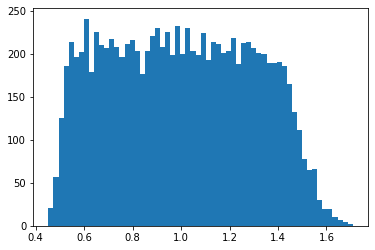

In [17]:
plt.hist(theta[:, 0].numpy() / theta[:, 1].numpy(), bins=60)

In [ ]:

key = jax.random.PRNGKey(88)

concentration = 2.0
rate = 20.
tmax = 10.

A=1.0

key,rng = jax.random.split(key)
decay_time = dist.Gamma(concentration=concentration, 
                        rate=rate).sample(key, (10000,))

key,rng = jax.random.split(key)
measurement_time = dist.Uniform(low=0.0, high=tmax).sample(key, (10000,))

key,rng = jax.random.split(key)
_lambda = A * jnp.exp(-measurement_time / decay_time )
measured_serum_level = dist.Poisson(rate=_lambda).sample(key, ())

In [ ]:
np.linspace(1, 10)

In [ ]:
rate

In [ ]:
concentration = 4.0
report_delay = 3 # days
rate = concentration / report_delay
tmax = 10.

A=1.0

key,rng = jax.random.split(key)
decay_time = dist.Gamma(concentration=concentration, 
                        rate=rate).sample(key, (10000,))
plt.hist(np.array(decay_time), bins=60)


# concentration = 2.0
# rate = 2.0 / 10

# decay_time = dist.Gamma(concentration=concentration, 
#                         rate=rate).sample(key, (10000,))
# plt.hist(np.array(decay_time), bins=60)

In [ ]:
plt.hist(np.array(decay_time), bins=60)

In [13]:
tfd = tfp.distributions
tfb = tfp.bijectors

In [15]:
maf = tfd.TransformedDistribution(
    distribution=tfd.Sample(
        tfd.Normal(loc=0., scale=1.), sample_shape=[2]),
    bijector=tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, hidden_units=[512, 512])))

In [16]:
maf.distribution = tfd.Sample(
        tfd.Normal(loc=0., scale=3.), sample_shape=[2])

AttributeError: can't set attribute

In [17]:
maf._distribution = tfd.Sample(
        tfd.Normal(loc=0., scale=3.), sample_shape=[2])

In [26]:
F.shape

TensorShape([10000, 2, 2])

In [66]:
mydist = tfd.Sample(
        tfd.MultivariateNormalFullCovariance(loc=0., 
        covariance_matrix=F[:]), sample_shape=[])

In [67]:
mydist.sample().numpy().shape

(10000, 2)

(array([[ 2.,  8.,  7., 22., 17., 18., 16.,  7.,  2.,  1.],
        [ 0.,  0.,  1., 18., 47., 30.,  4.,  0.,  0.,  0.]]),
 array([-24.42128302, -19.23787973, -14.05447645,  -8.87107316,
         -3.68766988,   1.4957334 ,   6.67913669,  11.86253997,
         17.04594326,  22.22934654,  27.41274983]),
 <a list of 2 BarContainer objects>)

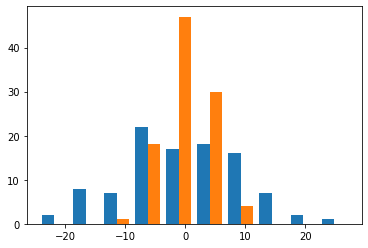

In [60]:
plt.hist(mydist.sample((100,)).numpy()[:, 0])

(array([ 2.,  2.,  4.,  9., 10.,  7.,  4.,  3.,  7.,  2.]),
 array([-1.1977313 , -0.96494275, -0.73215425, -0.49936578, -0.2665773 ,
        -0.0337888 ,  0.19899969,  0.43178818,  0.66457665,  0.89736515,
         1.1301537 ], dtype=float32),
 <BarContainer object of 10 artists>)

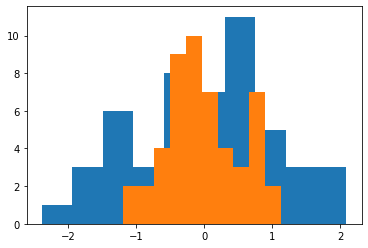

In [25]:
maf = tfd.TransformedDistribution(
    distribution=tfd.Sample(
        tfd.Normal(loc=0., scale=1.), sample_shape=[2]),
    bijector=tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, hidden_units=[512, 512])))


plt.hist(maf.distribution.sample((50,)).numpy()[:, 0])


maf._distribution = tfd.Sample(
        tfd.Normal(loc=0., scale=0.5), sample_shape=[2])
plt.hist(maf.distribution.sample((50,)).numpy()[:, 0])